In [115]:
# Fix convergence of GuSTO
# Create new environment? Yeah I guess we can try
# Plot new environment 
# Run GuSTO with different points, does it converge?
# Plot solution on top of new environment. Does it look good?
# Set up lots of initial and final points, and store resulting data

In [304]:
include("astrobee_se3_script.jl")
using Plots
using JLD2, FileIO

┌ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1186


In [305]:
function solve_gusto(model, N, MAX_ITERATIONS_NB, verbose = true)
    
    Xp,Up = initialize_trajectory(model, N)
    X, U  = copy(Xp)  , copy(Up) 

    SCPproblem = GuSTOProblem(model, N, Xp, Up)

    x_dim, u_dim = model.x_dim, model.u_dim

    Delta0, omega0, omegamax, 
        epsilon, rho0, rho1, 
        beta_succ, beta_fail, gamma_fail, 
        convergence_threshold = get_initial_gusto_parameters(model)

    Delta = Delta0
    omega = omega0

    X_all, U_all = [], []
    push!(X_all, copy(X))
    push!(U_all, copy(U))

    B_success = false
    it = 0

    while it<MAX_ITERATIONS_NB && 
            !(it!=0 && it!=1 && it!=2 && it!=3 && B_success && 
                convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
            omega<omegamax
        if verbose
            println("-----------")
            println("Iteration $it")
            println("metric=$(convergence_metric(model,X,U,Xp,Up))")
            println("-----------")
        end

        Xp = copy(X)
        Up = copy(U)

        model.f, model.A, model.B = compute_dynamics(model, Xp, Up)

        reset_problem(SCPproblem, model)
        set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
        define_cost(SCPproblem, model)
        define_constraints(SCPproblem, model)

        JuMP.optimize!(SCPproblem.solver_model)    
        p0 = get_initial_constraint_dual_variable(SCPproblem, model)
        if verbose
#             println("dual variables:", p0)
        end
        # get solution
        X_sol = JuMP.value.(SCPproblem.X)
        U_sol = JuMP.value.(SCPproblem.U)

        # try shooting
        #x_shooting, sol_newton = solve_shooting(SCPproblem, model, p0)
    #     x_shooting = solve_shooting_once(SCPproblem, model, p0)
        #push!(x_shooting_all, x_shooting)

        # -----------
        # GuSTO Logic
        if it > 3
            if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
                rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

                if rho > rho1
                    if verbose
                        println("Reject solution.")
                    end
                    Delta = beta_fail * Delta
                    omega     = omega
                    B_success = false

                else
                    if verbose
                        println("Accept solution.")
                    end
                    X = copy(X_sol)
                    U = copy(U_sol)
                    B_success = true
                    if rho < rho0
                        Delta = min(beta_succ*Delta, Delta0)
                    else
                        Delta = Delta
                    end
                    if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                        omega = omega0
                    else
                        if verbose
                            println("Solution does not satisfy state constraints, increasing omega.")
                        end
                        omega = gamma_fail * omega
                        B_success = false
                    end
                end
            else
                if verbose
                    println("Reject solution (Outside trust region)")
                end
                Delta = Delta
                omega     = gamma_fail * omega
                B_success = false
            end
    #         if convergence_metric(model,X,U,Xp,Up) <0.6
    #             println("Convergence metric very small. Decreasing Delta.")
    #             Delta = Delta0./(2^it)
    #         end

        else # always accept first solution
            X = copy(X_sol)
            U = copy(U_sol)
        end


        # -----------

        push!(X_all, copy(X))
        push!(U_all, copy(U))


        it += 1

        diff_with_prev = norm(copy(X) - copy(Xp), Inf)
        if verbose
            println("x(k) - x(k-1) = $diff_with_prev")
            println("Parameters:")
            println("omega=$omega")
            println("delta=$Delta")
        end
    end
    curr_conv_metric = convergence_metric(model,X,U,Xp,Up)
    if (B_success && 
                curr_conv_metric<convergence_threshold)
        if verbose
            println("Converged")
        end
        isConverged = true
    else
        if verbose
            println("Not converged. Metric =$curr_conv_metric")
        end
        isConverged = false
    end
    return isConverged, X_all, U_all
end

solve_gusto (generic function with 2 methods)

In [306]:
function isInsideObstacle(x, model)
    isInside = false
    for obs in model.obstacles
        center = obs[1]
        radius = obs[2]
        if norm(x[1:3] - center) < radius
            isInside = true
            return isInside
        end
    end
    return isInside
end

isInsideObstacle (generic function with 1 method)

In [307]:
function plot_solution(model, X_all)
    N = length(X_all)

    idx = [1,2]
    local fig
    fig = plot()
    for iter = 1:length(X_all)
        X = X_all[iter]
        plot!(fig, X[1,:], X[2,:]; c=:blue)
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius; color=:red, fig=fig)
    end

    return fig
end

plot_solution (generic function with 2 methods)

In [308]:
function plot_env_solution(model, X_all)
    N = length(X_all)

    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter ==1 
            color = :darkblue
            plot!(fig, X[1,:], X[2,:], line=(5, :dash); c=color, lab = "Initial guess")
        elseif iter == length(X_all)
            color = :green
            plot!(fig, X[1,:], X[2,:], line=(5, :dash), c=color, lab = "Final solution")
        else
            color = :blue
            plot!(fig, X[1,:], X[2,:]; c=color, lab = "")
        end
        
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(leg = true)
    return fig
end

plot_env_solution (generic function with 1 method)

In [309]:
function storeInputOutput(x_init, x_final, X_soln, U_soln)
    # X_soln # This is 13x50. I want this to be 1x13*50
    # U_soln # This is 6x 49. I want this to be 1x6*49
    X_row = (X_soln[:]) # 650 elements All at time 1 together (13), then next 13 for time 2, etc, 
    U_row = (U_soln[:]) # 294 elements All at time 1 together (6), then next 6 for time 2, etc.
    train_output = vcat([X_row, U_row]...)' # This is 944 elements
    train_input = vcat([x_init, x_final]...)' # This is 26 elements
    return train_input, train_output
end

storeInputOutput (generic function with 1 method)

# How to recover solutions from training data

In [310]:
function getComponentsFromData(train_input, train_output)
    N = 50 
    x_dim = 13
    u_dim = 6
    x_init = train_input[1:x_dim]
    x_final = train_input[x_dim+1:end]
    X_row = train_output[1:x_dim*N]
    X_soln = reshape(X_row, (x_dim,N))
    U_row = train_output[(1+x_dim*N) : end]
    U_soln = reshape(U_row, (u_dim,N-1))
    return x_init, x_final, X_soln, U_soln
end

getComponentsFromData (generic function with 1 method)

In [311]:
train_input, train_output = storeInputOutput(x_init, x_final, X_soln, U_soln)
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)
@show (x_init == x_init_recov)
@show (x_final == x_final_recov)
@show (X_soln == X_soln_recov)
@show (U_soln == U_soln_recov)

x_init == x_init_recov = true
x_final == x_final_recov = true
X_soln == X_soln_recov = true
U_soln == U_soln_recov = true


true

# Simple Case

In [150]:
N = 50
MAX_ITERATIONS_NB = 100

model = Astrobee()

model.x_init = [-0.25;0.4;0;  0;0;0;  0.;0.;0.; 1.;  0;0;0]
model.x_final = [0.7 ;-0.5;0;  0;0;0;  0.;0.;1.; 0.;  0;0;0]
model.tf_guess = 110.
model.convergence_threshold = 0.5
@show(model.obstacles)

time_start = time_ns()
isConverged, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, false)
gusto_solve_time = (time_ns() - time_start)/10^9
@show gusto_solve_time
@show size(X_all)
@show size(U_all)

model.obstacles = Any[Any[[0.0, 0.175, 0.0], 0.1], Any[[0.4, -0.1, 0.0], 0.1]]
gusto_solve_time = 2.374330701
size(X_all) = (7,)
size(U_all) = (7,)


(7,)

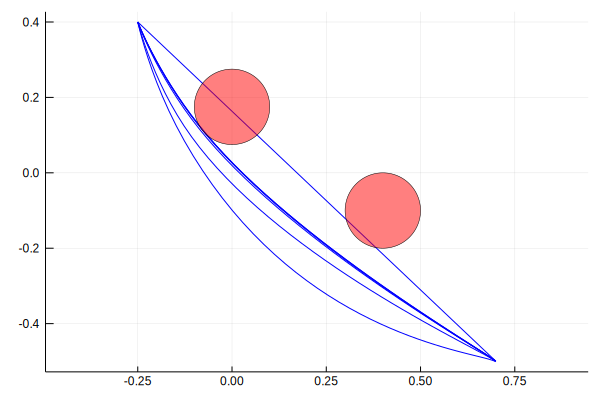

In [151]:
plot_solution(model, X_all)

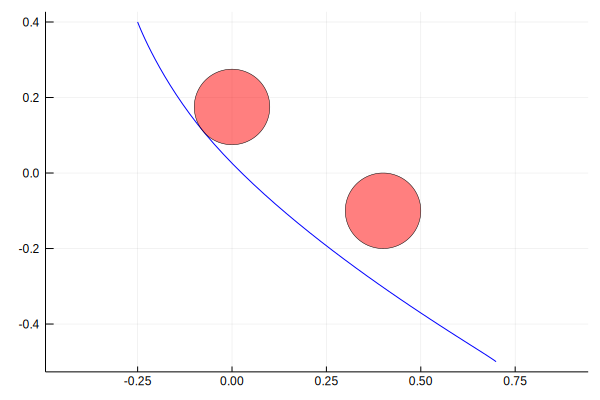

In [152]:
plot_solution(model, [X_all[end]])

# Around a corner

In [312]:
N = 50
MAX_ITERATIONS_NB = 100

model = Astrobee()

# Set up environment
model.x_max[1:3] = [10.0; 10.0; 10.0]
model.x_min[1:3] = [0.0; 0.0; 0.0]
model.obstacles = []
obs = [[0.0,0.0,0.0], 4.0]
push!(model.obstacles, obs)

model.x_init = [1.0;4.2;0;  0;0;0;  0.;0.;0.; 1.;  0;0;0]
model.x_final = [4.2 ;1.0;0;  0;0;0;  0.;0.;1.; 0.;  0;0;0]
model.tf_guess = 110.
model.convergence_threshold = 0.5
@show(model.obstacles)

time_start = time_ns()
isConverged, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, false)
gusto_solve_time = (time_ns() - time_start)/10^9
@show gusto_solve_time
@show size(X_all)
@show size(U_all)

model.obstacles = Any[Any[[0.0, 0.0, 0.0], 4.0]]
gusto_solve_time = 20.223696249
size(X_all) = (44,)
size(U_all) = (44,)


(44,)

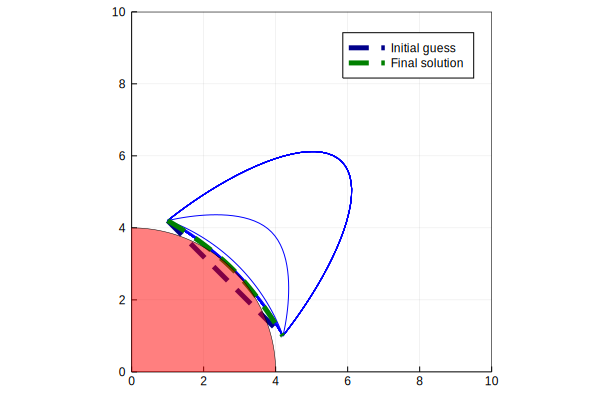

In [313]:
plot_env_solution(model, X_all)

In [314]:
N = 50
MAX_ITERATIONS_NB = 100

model = Astrobee()

# Set up environment
model.x_max[1:3] = [10.0; 10.0; 1.0]
model.x_min[1:3] = [0.0; 0.0; 0.0]
model.obstacles = []
obstacles = []
obs = [[0.0,0.0,0.0], 6.0]
push!(obstacles, obs)
obs = [[5.0,5.0,0.0], 1.3]
push!(obstacles, obs)
obs = [[3.0,5.0,0.0], 1.3]
push!(obstacles, obs)
obs = [[5.0,3.0,0.0], 1.3]
push!(obstacles, obs)
model.obstacles = obstacles

model.x_init = [3.0;7.0;0;  0;0;0;  0.;0.;0.; 1.;  0;0;0]
model.x_final = [7.0 ;3.0;0;  0;0;0;  0.;0.;1.; 0.;  0;0;0]
model.tf_guess = 110.
model.convergence_threshold = 0.5
@show(model.obstacles)

time_start = time_ns()
isConverged, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, false)
gusto_solve_time = (time_ns() - time_start)/10^9
@show gusto_solve_time
@show size(X_all)
@show size(U_all)

model.obstacles = Any[Any[[0.0, 0.0, 0.0], 6.0], Any[[5.0, 5.0, 0.0], 1.3], Any[[3.0, 5.0, 0.0], 1.3], Any[[5.0, 3.0, 0.0], 1.3]]
gusto_solve_time = 6.294147275
size(X_all) = (15,)
size(U_all) = (15,)


(15,)

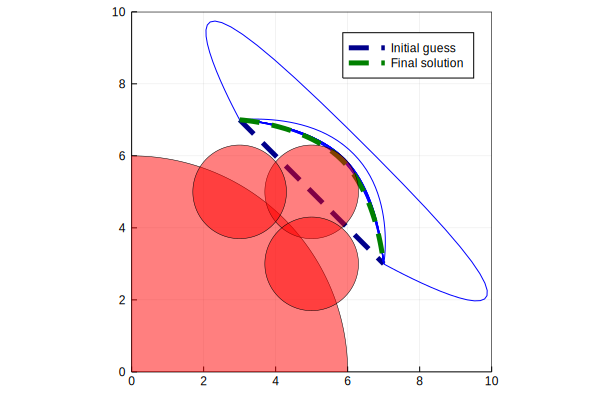

In [315]:
plot_env_solution(model, X_all)

# Collecting data

In [ ]:
N = 50
MAX_ITERATIONS_NB = 100

model = Astrobee()

# Set up environment
model.x_max[1:3] = [10.0; 10.0; 1.0]
model.x_min[1:3] = [0.0; 0.0; 0.0]
model.obstacles = []
obstacles = []
obs = [[0.0,0.0,0.0], 6.0]
push!(obstacles, obs)
obs = [[5.0,5.0,0.0], 1.3]
push!(obstacles, obs)
obs = [[3.0,5.0,0.0], 1.3]
push!(obstacles, obs)
obs = [[5.0,3.0,0.0], 1.3]
push!(obstacles, obs)
model.obstacles = obstacles

model.tf_guess = 110.
model.convergence_threshold = 0.5

x_vals = range(model.x_min[1], stop = model.x_max[1], length = 10)
y_vals = range(model.x_min[2], stop = model.x_max[2], length = 10)
z_vals = range(model.x_min[3], stop = model.x_max[3], length = 10)

x_vals_rev = range(model.x_max[1], stop = model.x_min[1], length = 10)
y_vals_rev = range(model.x_max[2], stop = model.x_min[2], length = 10)
z_vals_rev = range(model.x_max[3], stop = model.x_min[3], length = 10)

problemNumber = 0

train_input_collected = Array{Float64}(undef,0,26)
train_output_collected = Array{Float64}(undef,0,944)

for x_start in x_vals
    for y_start in y_vals
        for z_start in z_vals
            x_init = [x_start;y_start;z_start; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
            if isInsideObstacle(x_init, model)
                continue
            end
            for x_goal in x_vals_rev
                for y_goal in y_vals_rev
                    for z_goal in z_vals_rev
                        x_final = [x_goal;y_goal;z_goal; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
                        if isInsideObstacle(x_final, model)
                            continue
                        end
                        if norm(x_final[1:3] - x_init[1:3])<1.0
                            continue
                        end
                        
                        problemNumber = problemNumber + 1
                        @show problemNumber
                        
                        model.x_init = x_init
                        model.x_final = x_final
                        
                        try
                            isConverged, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, false)
                        catch e
                            println("$e")
                        end
                        @show isConverged
                        
                        if isConverged
                            X_soln = X_all[end]
                            U_soln = U_all[end]
                            train_input, train_output = storeInputOutput(x_init, x_final, X_soln, U_soln)                            
                            train_input_collected = vcat(train_input_collected, train_input)
                            train_output_collected = vcat(train_output_collected, train_output)
                            @show size(train_input_collected)
                            @show size(train_output_collected)
                            
                            @save "SimpleAstrobee.jld2" train_input_collected train_output_collected
                        end
                    end
                end
            end
        end
    end
end
plot_env_solution(model, X_all)

problemNumber = 1
isConverged = true
size(train_input_collected) = (1, 26)
size(train_output_collected) = (1, 944)
problemNumber = 2
isConverged = true
size(train_input_collected) = (2, 26)
size(train_output_collected) = (2, 944)
problemNumber = 3
isConverged = true
size(train_input_collected) = (3, 26)
size(train_output_collected) = (3, 944)
problemNumber = 4
isConverged = true
size(train_input_collected) = (4, 26)
size(train_output_collected) = (4, 944)
problemNumber = 5
isConverged = true
size(train_input_collected) = (5, 26)
size(train_output_collected) = (5, 944)
problemNumber = 6
isConverged = true
size(train_input_collected) = (6, 26)
size(train_output_collected) = (6, 944)
problemNumber = 7
isConverged = true
size(train_input_collected) = (7, 26)
size(train_output_collected) = (7, 944)
problemNumber = 8
isConverged = true
size(train_input_collected) = (8, 26)
size(train_output_collected) = (8, 944)
problemNumber = 9
isConverged = true
size(train_input_collected) = (9, 26)
size(

isConverged = false
problemNumber = 75
isConverged = false
problemNumber = 76
isConverged = false
problemNumber = 77
isConverged = false
problemNumber = 78
isConverged = true
size(train_input_collected) = (70, 26)
size(train_output_collected) = (70, 944)
problemNumber = 79
isConverged = false
problemNumber = 80
isConverged = false
problemNumber = 81
isConverged = false
problemNumber = 82
isConverged = false
problemNumber = 83
isConverged = false
problemNumber = 84
isConverged = false
problemNumber = 85
isConverged = false
problemNumber = 86
isConverged = false
problemNumber = 87
isConverged = false
problemNumber = 88
isConverged = true
size(train_input_collected) = (71, 26)
size(train_output_collected) = (71, 944)
problemNumber = 89
isConverged = true
size(train_input_collected) = (72, 26)
size(train_output_collected) = (72, 944)
problemNumber = 90
isConverged = false
problemNumber = 91
isConverged = false
problemNumber = 92
isConverged = false
problemNumber = 93
isConverged = true
siz

isConverged = true
size(train_input_collected) = (132, 26)
size(train_output_collected) = (132, 944)
problemNumber = 159
isConverged = true
size(train_input_collected) = (133, 26)
size(train_output_collected) = (133, 944)
problemNumber = 160
isConverged = true
size(train_input_collected) = (134, 26)
size(train_output_collected) = (134, 944)
problemNumber = 161
isConverged = true
size(train_input_collected) = (135, 26)
size(train_output_collected) = (135, 944)
problemNumber = 162
isConverged = true
size(train_input_collected) = (136, 26)
size(train_output_collected) = (136, 944)
problemNumber = 163
isConverged = false
problemNumber = 164
isConverged = true
size(train_input_collected) = (137, 26)
size(train_output_collected) = (137, 944)
problemNumber = 165
isConverged = false
problemNumber = 166
isConverged = true
size(train_input_collected) = (138, 26)
size(train_output_collected) = (138, 944)
problemNumber = 167
isConverged = false
problemNumber = 168
isConverged = true
size(train_inp

isConverged = true
size(train_input_collected) = (194, 26)
size(train_output_collected) = (194, 944)
problemNumber = 240
isConverged = false
problemNumber = 241
isConverged = true
size(train_input_collected) = (195, 26)
size(train_output_collected) = (195, 944)
problemNumber = 242
isConverged = true
size(train_input_collected) = (196, 26)
size(train_output_collected) = (196, 944)
problemNumber = 243
isConverged = true
size(train_input_collected) = (197, 26)
size(train_output_collected) = (197, 944)
problemNumber = 244
isConverged = true
size(train_input_collected) = (198, 26)
size(train_output_collected) = (198, 944)
problemNumber = 245
isConverged = true
size(train_input_collected) = (199, 26)
size(train_output_collected) = (199, 944)
problemNumber = 246
isConverged = true
size(train_input_collected) = (200, 26)
size(train_output_collected) = (200, 944)
problemNumber = 247
isConverged = true
size(train_input_collected) = (201, 26)
size(train_output_collected) = (201, 944)
problemNumbe

isConverged = false
problemNumber = 413
isConverged = true
size(train_input_collected) = (312, 26)
size(train_output_collected) = (312, 944)
problemNumber = 414
isConverged = true
size(train_input_collected) = (313, 26)
size(train_output_collected) = (313, 944)
problemNumber = 415
isConverged = true
size(train_input_collected) = (314, 26)
size(train_output_collected) = (314, 944)
problemNumber = 416
isConverged = true
size(train_input_collected) = (315, 26)
size(train_output_collected) = (315, 944)
problemNumber = 417
isConverged = true
size(train_input_collected) = (316, 26)
size(train_output_collected) = (316, 944)
problemNumber = 418
isConverged = true
size(train_input_collected) = (317, 26)
size(train_output_collected) = (317, 944)
problemNumber = 419
isConverged = false
problemNumber = 420
isConverged = true
size(train_input_collected) = (318, 26)
size(train_output_collected) = (318, 944)
problemNumber = 421
isConverged = true
size(train_input_collected) = (319, 26)
size(train_out

isConverged = true
size(train_input_collected) = (378, 26)
size(train_output_collected) = (378, 944)
problemNumber = 485
isConverged = true
size(train_input_collected) = (379, 26)
size(train_output_collected) = (379, 944)
problemNumber = 486
isConverged = true
size(train_input_collected) = (380, 26)
size(train_output_collected) = (380, 944)
problemNumber = 487
isConverged = true
size(train_input_collected) = (381, 26)
size(train_output_collected) = (381, 944)
problemNumber = 488
isConverged = true
size(train_input_collected) = (382, 26)
size(train_output_collected) = (382, 944)
problemNumber = 489
isConverged = true
size(train_input_collected) = (383, 26)
size(train_output_collected) = (383, 944)
problemNumber = 490
isConverged = true
size(train_input_collected) = (384, 26)
size(train_output_collected) = (384, 944)
problemNumber = 491
isConverged = true
size(train_input_collected) = (385, 26)
size(train_output_collected) = (385, 944)
problemNumber = 492
isConverged = true
size(train_in

isConverged = true
size(train_input_collected) = (512, 26)
size(train_output_collected) = (512, 944)
problemNumber = 624
isConverged = true
size(train_input_collected) = (513, 26)
size(train_output_collected) = (513, 944)
problemNumber = 625
isConverged = true
size(train_input_collected) = (514, 26)
size(train_output_collected) = (514, 944)
problemNumber = 626
isConverged = true
size(train_input_collected) = (515, 26)
size(train_output_collected) = (515, 944)
problemNumber = 627
isConverged = true
size(train_input_collected) = (516, 26)
size(train_output_collected) = (516, 944)
problemNumber = 628
isConverged = true
size(train_input_collected) = (517, 26)
size(train_output_collected) = (517, 944)
problemNumber = 629
isConverged = true
size(train_input_collected) = (518, 26)
size(train_output_collected) = (518, 944)
problemNumber = 630
isConverged = true
size(train_input_collected) = (519, 26)
size(train_output_collected) = (519, 944)
problemNumber = 631
isConverged = true
size(train_in

isConverged = true
size(train_input_collected) = (580, 26)
size(train_output_collected) = (580, 944)
problemNumber = 692
isConverged = true
size(train_input_collected) = (581, 26)
size(train_output_collected) = (581, 944)
problemNumber = 693
isConverged = true
size(train_input_collected) = (582, 26)
size(train_output_collected) = (582, 944)
problemNumber = 694
isConverged = true
size(train_input_collected) = (583, 26)
size(train_output_collected) = (583, 944)
problemNumber = 695
isConverged = true
size(train_input_collected) = (584, 26)
size(train_output_collected) = (584, 944)
problemNumber = 696
isConverged = true
size(train_input_collected) = (585, 26)
size(train_output_collected) = (585, 944)
problemNumber = 697
isConverged = true
size(train_input_collected) = (586, 26)
size(train_output_collected) = (586, 944)
problemNumber = 698
isConverged = true
size(train_input_collected) = (587, 26)
size(train_output_collected) = (587, 944)
problemNumber = 699
isConverged = true
size(train_in

isConverged = true
size(train_input_collected) = (647, 26)
size(train_output_collected) = (647, 944)
problemNumber = 762
isConverged = true
size(train_input_collected) = (648, 26)
size(train_output_collected) = (648, 944)
problemNumber = 763
isConverged = true
size(train_input_collected) = (649, 26)
size(train_output_collected) = (649, 944)
problemNumber = 764
isConverged = true
size(train_input_collected) = (650, 26)
size(train_output_collected) = (650, 944)
problemNumber = 765
isConverged = true
size(train_input_collected) = (651, 26)
size(train_output_collected) = (651, 944)
problemNumber = 766
isConverged = true
size(train_input_collected) = (652, 26)
size(train_output_collected) = (652, 944)
problemNumber = 767
isConverged = true
size(train_input_collected) = (653, 26)
size(train_output_collected) = (653, 944)
problemNumber = 768
isConverged = true
size(train_input_collected) = (654, 26)
size(train_output_collected) = (654, 944)
problemNumber = 769
isConverged = true
size(train_in

isConverged = true
size(train_input_collected) = (781, 26)
size(train_output_collected) = (781, 944)
problemNumber = 901
isConverged = false
problemNumber = 902
isConverged = true
size(train_input_collected) = (782, 26)
size(train_output_collected) = (782, 944)
problemNumber = 903
isConverged = true
size(train_input_collected) = (783, 26)
size(train_output_collected) = (783, 944)
problemNumber = 904
isConverged = true
size(train_input_collected) = (784, 26)
size(train_output_collected) = (784, 944)
problemNumber = 905
isConverged = false
problemNumber = 906
isConverged = false
problemNumber = 907
isConverged = true
size(train_input_collected) = (785, 26)
size(train_output_collected) = (785, 944)
problemNumber = 908
isConverged = false
problemNumber = 909
isConverged = true
size(train_input_collected) = (786, 26)
size(train_output_collected) = (786, 944)
problemNumber = 910
isConverged = false
problemNumber = 911
isConverged = true
size(train_input_collected) = (787, 26)
size(train_outp

isConverged = true
size(train_input_collected) = (847, 26)
size(train_output_collected) = (847, 944)
problemNumber = 974
isConverged = true
size(train_input_collected) = (848, 26)
size(train_output_collected) = (848, 944)
problemNumber = 975
isConverged = true
size(train_input_collected) = (849, 26)
size(train_output_collected) = (849, 944)
problemNumber = 976
isConverged = true
size(train_input_collected) = (850, 26)
size(train_output_collected) = (850, 944)
problemNumber = 977
isConverged = true
size(train_input_collected) = (851, 26)
size(train_output_collected) = (851, 944)
problemNumber = 978
isConverged = true
size(train_input_collected) = (852, 26)
size(train_output_collected) = (852, 944)
problemNumber = 979
isConverged = true
size(train_input_collected) = (853, 26)
size(train_output_collected) = (853, 944)
problemNumber = 980
isConverged = true
size(train_input_collected) = (854, 26)
size(train_output_collected) = (854, 944)
problemNumber = 981
isConverged = true
size(train_in

isConverged = true
size(train_input_collected) = (910, 26)
size(train_output_collected) = (910, 944)
problemNumber = 1051
isConverged = true
size(train_input_collected) = (911, 26)
size(train_output_collected) = (911, 944)
problemNumber = 1052
isConverged = true
size(train_input_collected) = (912, 26)
size(train_output_collected) = (912, 944)
problemNumber = 1053
isConverged = true
size(train_input_collected) = (913, 26)
size(train_output_collected) = (913, 944)
problemNumber = 1054
isConverged = true
size(train_input_collected) = (914, 26)
size(train_output_collected) = (914, 944)
problemNumber = 1055
isConverged = true
size(train_input_collected) = (915, 26)
size(train_output_collected) = (915, 944)
problemNumber = 1056
isConverged = true
size(train_input_collected) = (916, 26)
size(train_output_collected) = (916, 944)
problemNumber = 1057
isConverged = true
size(train_input_collected) = (917, 26)
size(train_output_collected) = (917, 944)
problemNumber = 1058
isConverged = true
size(

isConverged = true
size(train_input_collected) = (978, 26)
size(train_output_collected) = (978, 944)
problemNumber = 1119
isConverged = true
size(train_input_collected) = (979, 26)
size(train_output_collected) = (979, 944)
problemNumber = 1120
isConverged = true
size(train_input_collected) = (980, 26)
size(train_output_collected) = (980, 944)
problemNumber = 1121
isConverged = true
size(train_input_collected) = (981, 26)
size(train_output_collected) = (981, 944)
problemNumber = 1122
isConverged = true
size(train_input_collected) = (982, 26)
size(train_output_collected) = (982, 944)
problemNumber = 1123
isConverged = true
size(train_input_collected) = (983, 26)
size(train_output_collected) = (983, 944)
problemNumber = 1124
isConverged = true
size(train_input_collected) = (984, 26)
size(train_output_collected) = (984, 944)
problemNumber = 1125
isConverged = true
size(train_input_collected) = (985, 26)
size(train_output_collected) = (985, 944)
problemNumber = 1126
isConverged = true
size(

isConverged = true
size(train_input_collected) = (1045, 26)
size(train_output_collected) = (1045, 944)
problemNumber = 1186
isConverged = true
size(train_input_collected) = (1046, 26)
size(train_output_collected) = (1046, 944)
problemNumber = 1187
isConverged = true
size(train_input_collected) = (1047, 26)
size(train_output_collected) = (1047, 944)
problemNumber = 1188
isConverged = true
size(train_input_collected) = (1048, 26)
size(train_output_collected) = (1048, 944)
problemNumber = 1189
isConverged = true
size(train_input_collected) = (1049, 26)
size(train_output_collected) = (1049, 944)
problemNumber = 1190
isConverged = true
size(train_input_collected) = (1050, 26)
size(train_output_collected) = (1050, 944)
problemNumber = 1191
isConverged = true
size(train_input_collected) = (1051, 26)
size(train_output_collected) = (1051, 944)
problemNumber = 1192
isConverged = true
size(train_input_collected) = (1052, 26)
size(train_output_collected) = (1052, 944)
problemNumber = 1193
isConver

isConverged = true
size(train_input_collected) = (1177, 26)
size(train_output_collected) = (1177, 944)
problemNumber = 1318
isConverged = true
size(train_input_collected) = (1178, 26)
size(train_output_collected) = (1178, 944)
problemNumber = 1319
isConverged = true
size(train_input_collected) = (1179, 26)
size(train_output_collected) = (1179, 944)
problemNumber = 1320
isConverged = true
size(train_input_collected) = (1180, 26)
size(train_output_collected) = (1180, 944)
problemNumber = 1321
isConverged = true
size(train_input_collected) = (1181, 26)
size(train_output_collected) = (1181, 944)
problemNumber = 1322
isConverged = true
size(train_input_collected) = (1182, 26)
size(train_output_collected) = (1182, 944)
problemNumber = 1323
isConverged = true
size(train_input_collected) = (1183, 26)
size(train_output_collected) = (1183, 944)
problemNumber = 1324
isConverged = true
size(train_input_collected) = (1184, 26)
size(train_output_collected) = (1184, 944)
problemNumber = 1325
isConver

isConverged = true
size(train_input_collected) = (1243, 26)
size(train_output_collected) = (1243, 944)
problemNumber = 1385
isConverged = true
size(train_input_collected) = (1244, 26)
size(train_output_collected) = (1244, 944)
problemNumber = 1386
isConverged = true
size(train_input_collected) = (1245, 26)
size(train_output_collected) = (1245, 944)
problemNumber = 1387
isConverged = true
size(train_input_collected) = (1246, 26)
size(train_output_collected) = (1246, 944)
problemNumber = 1388
isConverged = true
size(train_input_collected) = (1247, 26)
size(train_output_collected) = (1247, 944)
problemNumber = 1389
isConverged = true
size(train_input_collected) = (1248, 26)
size(train_output_collected) = (1248, 944)
problemNumber = 1390
isConverged = true
size(train_input_collected) = (1249, 26)
size(train_output_collected) = (1249, 944)
problemNumber = 1391
isConverged = true
size(train_input_collected) = (1250, 26)
size(train_output_collected) = (1250, 944)
problemNumber = 1392
isConver

isConverged = true
size(train_input_collected) = (1374, 26)
size(train_output_collected) = (1374, 944)
problemNumber = 1520
isConverged = true
size(train_input_collected) = (1375, 26)
size(train_output_collected) = (1375, 944)
problemNumber = 1521
isConverged = true
size(train_input_collected) = (1376, 26)
size(train_output_collected) = (1376, 944)
problemNumber = 1522
isConverged = true
size(train_input_collected) = (1377, 26)
size(train_output_collected) = (1377, 944)
problemNumber = 1523
isConverged = true
size(train_input_collected) = (1378, 26)
size(train_output_collected) = (1378, 944)
problemNumber = 1524
isConverged = true
size(train_input_collected) = (1379, 26)
size(train_output_collected) = (1379, 944)
problemNumber = 1525
isConverged = true
size(train_input_collected) = (1380, 26)
size(train_output_collected) = (1380, 944)
problemNumber = 1526
isConverged = true
size(train_input_collected) = (1381, 26)
size(train_output_collected) = (1381, 944)
problemNumber = 1527
isConver

isConverged = true
size(train_input_collected) = (1438, 26)
size(train_output_collected) = (1438, 944)
problemNumber = 1591
isConverged = true
size(train_input_collected) = (1439, 26)
size(train_output_collected) = (1439, 944)
problemNumber = 1592
isConverged = true
size(train_input_collected) = (1440, 26)
size(train_output_collected) = (1440, 944)
problemNumber = 1593
isConverged = true
size(train_input_collected) = (1441, 26)
size(train_output_collected) = (1441, 944)
problemNumber = 1594
isConverged = true
size(train_input_collected) = (1442, 26)
size(train_output_collected) = (1442, 944)
problemNumber = 1595
isConverged = true
size(train_input_collected) = (1443, 26)
size(train_output_collected) = (1443, 944)
problemNumber = 1596
isConverged = true
size(train_input_collected) = (1444, 26)
size(train_output_collected) = (1444, 944)
problemNumber = 1597
isConverged = true
size(train_input_collected) = (1445, 26)
size(train_output_collected) = (1445, 944)
problemNumber = 1598
isConver

isConverged = false
problemNumber = 1669
isConverged = true
size(train_input_collected) = (1499, 26)
size(train_output_collected) = (1499, 944)
problemNumber = 1670
isConverged = true
size(train_input_collected) = (1500, 26)
size(train_output_collected) = (1500, 944)
problemNumber = 1671
isConverged = true
size(train_input_collected) = (1501, 26)
size(train_output_collected) = (1501, 944)
problemNumber = 1672
isConverged = true
size(train_input_collected) = (1502, 26)
size(train_output_collected) = (1502, 944)
problemNumber = 1673
isConverged = true
size(train_input_collected) = (1503, 26)
size(train_output_collected) = (1503, 944)
problemNumber = 1674
isConverged = true
size(train_input_collected) = (1504, 26)
size(train_output_collected) = (1504, 944)
problemNumber = 1675
isConverged = true
size(train_input_collected) = (1505, 26)
size(train_output_collected) = (1505, 944)
problemNumber = 1676
isConverged = true
size(train_input_collected) = (1506, 26)
size(train_output_collected) = 

isConverged = true
size(train_input_collected) = (1565, 26)
size(train_output_collected) = (1565, 944)
problemNumber = 1736
isConverged = true
size(train_input_collected) = (1566, 26)
size(train_output_collected) = (1566, 944)
problemNumber = 1737
isConverged = true
size(train_input_collected) = (1567, 26)
size(train_output_collected) = (1567, 944)
problemNumber = 1738
isConverged = true
size(train_input_collected) = (1568, 26)
size(train_output_collected) = (1568, 944)
problemNumber = 1739
isConverged = true
size(train_input_collected) = (1569, 26)
size(train_output_collected) = (1569, 944)
problemNumber = 1740
isConverged = true
size(train_input_collected) = (1570, 26)
size(train_output_collected) = (1570, 944)
problemNumber = 1741
isConverged = true
size(train_input_collected) = (1571, 26)
size(train_output_collected) = (1571, 944)
problemNumber = 1742
isConverged = true
size(train_input_collected) = (1572, 26)
size(train_output_collected) = (1572, 944)
problemNumber = 1743
isConver

isConverged = true
size(train_input_collected) = (1697, 26)
size(train_output_collected) = (1697, 944)
problemNumber = 1868
isConverged = true
size(train_input_collected) = (1698, 26)
size(train_output_collected) = (1698, 944)
problemNumber = 1869
isConverged = true
size(train_input_collected) = (1699, 26)
size(train_output_collected) = (1699, 944)
problemNumber = 1870
isConverged = true
size(train_input_collected) = (1700, 26)
size(train_output_collected) = (1700, 944)
problemNumber = 1871
isConverged = true
size(train_input_collected) = (1701, 26)
size(train_output_collected) = (1701, 944)
problemNumber = 1872
isConverged = true
size(train_input_collected) = (1702, 26)
size(train_output_collected) = (1702, 944)
problemNumber = 1873
isConverged = true
size(train_input_collected) = (1703, 26)
size(train_output_collected) = (1703, 944)
problemNumber = 1874
isConverged = true
size(train_input_collected) = (1704, 26)
size(train_output_collected) = (1704, 944)
problemNumber = 1875
isConver

isConverged = false
problemNumber = 2002
isConverged = true
size(train_input_collected) = (1828, 26)
size(train_output_collected) = (1828, 944)
problemNumber = 2003
isConverged = true
size(train_input_collected) = (1829, 26)
size(train_output_collected) = (1829, 944)
problemNumber = 2004
isConverged = true
size(train_input_collected) = (1830, 26)
size(train_output_collected) = (1830, 944)
problemNumber = 2005
isConverged = true
size(train_input_collected) = (1831, 26)
size(train_output_collected) = (1831, 944)
problemNumber = 2006
isConverged = true
size(train_input_collected) = (1832, 26)
size(train_output_collected) = (1832, 944)
problemNumber = 2007
isConverged = true
size(train_input_collected) = (1833, 26)
size(train_output_collected) = (1833, 944)
problemNumber = 2008
isConverged = true
size(train_input_collected) = (1834, 26)
size(train_output_collected) = (1834, 944)
problemNumber = 2009
isConverged = true
size(train_input_collected) = (1835, 26)
size(train_output_collected) = 

isConverged = true
size(train_input_collected) = (1894, 26)
size(train_output_collected) = (1894, 944)
problemNumber = 2069
isConverged = true
size(train_input_collected) = (1895, 26)
size(train_output_collected) = (1895, 944)
problemNumber = 2070
isConverged = true
size(train_input_collected) = (1896, 26)
size(train_output_collected) = (1896, 944)
problemNumber = 2071
isConverged = true
size(train_input_collected) = (1897, 26)
size(train_output_collected) = (1897, 944)
problemNumber = 2072
isConverged = true
size(train_input_collected) = (1898, 26)
size(train_output_collected) = (1898, 944)
problemNumber = 2073
isConverged = true
size(train_input_collected) = (1899, 26)
size(train_output_collected) = (1899, 944)
problemNumber = 2074
isConverged = true
size(train_input_collected) = (1900, 26)
size(train_output_collected) = (1900, 944)
problemNumber = 2075
isConverged = true
size(train_input_collected) = (1901, 26)
size(train_output_collected) = (1901, 944)
problemNumber = 2076
isConver

isConverged = true
size(train_input_collected) = (1959, 26)
size(train_output_collected) = (1959, 944)
problemNumber = 2138
isConverged = true
size(train_input_collected) = (1960, 26)
size(train_output_collected) = (1960, 944)
problemNumber = 2139
isConverged = true
size(train_input_collected) = (1961, 26)
size(train_output_collected) = (1961, 944)
problemNumber = 2140
isConverged = true
size(train_input_collected) = (1962, 26)
size(train_output_collected) = (1962, 944)
problemNumber = 2141
isConverged = true
size(train_input_collected) = (1963, 26)
size(train_output_collected) = (1963, 944)
problemNumber = 2142
isConverged = true
size(train_input_collected) = (1964, 26)
size(train_output_collected) = (1964, 944)
problemNumber = 2143
isConverged = true
size(train_input_collected) = (1965, 26)
size(train_output_collected) = (1965, 944)
problemNumber = 2144
isConverged = true
size(train_input_collected) = (1966, 26)
size(train_output_collected) = (1966, 944)
problemNumber = 2145
isConver

isConverged = true
size(train_input_collected) = (2021, 26)
size(train_output_collected) = (2021, 944)
problemNumber = 2213
isConverged = true
size(train_input_collected) = (2022, 26)
size(train_output_collected) = (2022, 944)
problemNumber = 2214
isConverged = true
size(train_input_collected) = (2023, 26)
size(train_output_collected) = (2023, 944)
problemNumber = 2215
isConverged = true
size(train_input_collected) = (2024, 26)
size(train_output_collected) = (2024, 944)
problemNumber = 2216
isConverged = true
size(train_input_collected) = (2025, 26)
size(train_output_collected) = (2025, 944)
problemNumber = 2217
isConverged = true
size(train_input_collected) = (2026, 26)
size(train_output_collected) = (2026, 944)
problemNumber = 2218
isConverged = true
size(train_input_collected) = (2027, 26)
size(train_output_collected) = (2027, 944)
problemNumber = 2219
isConverged = true
size(train_input_collected) = (2028, 26)
size(train_output_collected) = (2028, 944)
problemNumber = 2220
isConver

isConverged = true
size(train_input_collected) = (2148, 26)
size(train_output_collected) = (2148, 944)
problemNumber = 2356
isConverged = true
size(train_input_collected) = (2149, 26)
size(train_output_collected) = (2149, 944)
problemNumber = 2357
isConverged = true
size(train_input_collected) = (2150, 26)
size(train_output_collected) = (2150, 944)
problemNumber = 2358
isConverged = true
size(train_input_collected) = (2151, 26)
size(train_output_collected) = (2151, 944)
problemNumber = 2359
isConverged = true
size(train_input_collected) = (2152, 26)
size(train_output_collected) = (2152, 944)
problemNumber = 2360
isConverged = true
size(train_input_collected) = (2153, 26)
size(train_output_collected) = (2153, 944)
problemNumber = 2361
isConverged = true
size(train_input_collected) = (2154, 26)
size(train_output_collected) = (2154, 944)
problemNumber = 2362
isConverged = true
size(train_input_collected) = (2155, 26)
size(train_output_collected) = (2155, 944)
problemNumber = 2363
isConver

isConverged = true
size(train_input_collected) = (2280, 26)
size(train_output_collected) = (2280, 944)
problemNumber = 2488
isConverged = true
size(train_input_collected) = (2281, 26)
size(train_output_collected) = (2281, 944)
problemNumber = 2489
isConverged = true
size(train_input_collected) = (2282, 26)
size(train_output_collected) = (2282, 944)
problemNumber = 2490
isConverged = true
size(train_input_collected) = (2283, 26)
size(train_output_collected) = (2283, 944)
problemNumber = 2491
isConverged = true
size(train_input_collected) = (2284, 26)
size(train_output_collected) = (2284, 944)
problemNumber = 2492
isConverged = true
size(train_input_collected) = (2285, 26)
size(train_output_collected) = (2285, 944)
problemNumber = 2493
isConverged = true
size(train_input_collected) = (2286, 26)
size(train_output_collected) = (2286, 944)
problemNumber = 2494
isConverged = true
size(train_input_collected) = (2287, 26)
size(train_output_collected) = (2287, 944)
problemNumber = 2495
isConver

isConverged = true
size(train_input_collected) = (2412, 26)
size(train_output_collected) = (2412, 944)
problemNumber = 2621
isConverged = true
size(train_input_collected) = (2413, 26)
size(train_output_collected) = (2413, 944)
problemNumber = 2622
isConverged = true
size(train_input_collected) = (2414, 26)
size(train_output_collected) = (2414, 944)
problemNumber = 2623
isConverged = true
size(train_input_collected) = (2415, 26)
size(train_output_collected) = (2415, 944)
problemNumber = 2624
isConverged = true
size(train_input_collected) = (2416, 26)
size(train_output_collected) = (2416, 944)
problemNumber = 2625
isConverged = true
size(train_input_collected) = (2417, 26)
size(train_output_collected) = (2417, 944)
problemNumber = 2626
isConverged = true
size(train_input_collected) = (2418, 26)
size(train_output_collected) = (2418, 944)
problemNumber = 2627
isConverged = true
size(train_input_collected) = (2419, 26)
size(train_output_collected) = (2419, 944)
problemNumber = 2628
isConver

isConverged = true
size(train_input_collected) = (2478, 26)
size(train_output_collected) = (2478, 944)
problemNumber = 2688
isConverged = true
size(train_input_collected) = (2479, 26)
size(train_output_collected) = (2479, 944)
problemNumber = 2689
isConverged = true
size(train_input_collected) = (2480, 26)
size(train_output_collected) = (2480, 944)
problemNumber = 2690
isConverged = true
size(train_input_collected) = (2481, 26)
size(train_output_collected) = (2481, 944)
problemNumber = 2691
isConverged = true
size(train_input_collected) = (2482, 26)
size(train_output_collected) = (2482, 944)
problemNumber = 2692
isConverged = true
size(train_input_collected) = (2483, 26)
size(train_output_collected) = (2483, 944)
problemNumber = 2693
isConverged = true
size(train_input_collected) = (2484, 26)
size(train_output_collected) = (2484, 944)
problemNumber = 2694
isConverged = true
size(train_input_collected) = (2485, 26)
size(train_output_collected) = (2485, 944)
problemNumber = 2695
isConver

isConverged = true
size(train_input_collected) = (2542, 26)
size(train_output_collected) = (2542, 944)
problemNumber = 2759
isConverged = true
size(train_input_collected) = (2543, 26)
size(train_output_collected) = (2543, 944)
problemNumber = 2760
isConverged = true
size(train_input_collected) = (2544, 26)
size(train_output_collected) = (2544, 944)
problemNumber = 2761
isConverged = true
size(train_input_collected) = (2545, 26)
size(train_output_collected) = (2545, 944)
problemNumber = 2762
isConverged = true
size(train_input_collected) = (2546, 26)
size(train_output_collected) = (2546, 944)
problemNumber = 2763
isConverged = true
size(train_input_collected) = (2547, 26)
size(train_output_collected) = (2547, 944)
problemNumber = 2764
isConverged = true
size(train_input_collected) = (2548, 26)
size(train_output_collected) = (2548, 944)
problemNumber = 2765
isConverged = true
size(train_input_collected) = (2549, 26)
size(train_output_collected) = (2549, 944)
problemNumber = 2766
isConver

isConverged = true
size(train_input_collected) = (2671, 26)
size(train_output_collected) = (2671, 944)
problemNumber = 2898
isConverged = true
size(train_input_collected) = (2672, 26)
size(train_output_collected) = (2672, 944)
problemNumber = 2899
isConverged = false
problemNumber = 2900
isConverged = true
size(train_input_collected) = (2673, 26)
size(train_output_collected) = (2673, 944)
problemNumber = 2901
isConverged = true
size(train_input_collected) = (2674, 26)
size(train_output_collected) = (2674, 944)
problemNumber = 2902
isConverged = true
size(train_input_collected) = (2675, 26)
size(train_output_collected) = (2675, 944)
problemNumber = 2903
isConverged = false
problemNumber = 2904
isConverged = true
size(train_input_collected) = (2676, 26)
size(train_output_collected) = (2676, 944)
problemNumber = 2905
isConverged = true
size(train_input_collected) = (2677, 26)
size(train_output_collected) = (2677, 944)
problemNumber = 2906
isConverged = true
size(train_input_collected) = (

isConverged = true
size(train_input_collected) = (2798, 26)
size(train_output_collected) = (2798, 944)
problemNumber = 3041
isConverged = true
size(train_input_collected) = (2799, 26)
size(train_output_collected) = (2799, 944)
problemNumber = 3042
isConverged = true
size(train_input_collected) = (2800, 26)
size(train_output_collected) = (2800, 944)
problemNumber = 3043
isConverged = true
size(train_input_collected) = (2801, 26)
size(train_output_collected) = (2801, 944)
problemNumber = 3044
isConverged = true
size(train_input_collected) = (2802, 26)
size(train_output_collected) = (2802, 944)
problemNumber = 3045
isConverged = true
size(train_input_collected) = (2803, 26)
size(train_output_collected) = (2803, 944)
problemNumber = 3046
isConverged = true
size(train_input_collected) = (2804, 26)
size(train_output_collected) = (2804, 944)
problemNumber = 3047
isConverged = true
size(train_input_collected) = (2805, 26)
size(train_output_collected) = (2805, 944)
problemNumber = 3048
isConver

isConverged = true
size(train_input_collected) = (2930, 26)
size(train_output_collected) = (2930, 944)
problemNumber = 3173
isConverged = true
size(train_input_collected) = (2931, 26)
size(train_output_collected) = (2931, 944)
problemNumber = 3174
isConverged = true
size(train_input_collected) = (2932, 26)
size(train_output_collected) = (2932, 944)
problemNumber = 3175
isConverged = true
size(train_input_collected) = (2933, 26)
size(train_output_collected) = (2933, 944)
problemNumber = 3176
isConverged = true
size(train_input_collected) = (2934, 26)
size(train_output_collected) = (2934, 944)
problemNumber = 3177
isConverged = true
size(train_input_collected) = (2935, 26)
size(train_output_collected) = (2935, 944)
problemNumber = 3178
isConverged = true
size(train_input_collected) = (2936, 26)
size(train_output_collected) = (2936, 944)
problemNumber = 3179
isConverged = true
size(train_input_collected) = (2937, 26)
size(train_output_collected) = (2937, 944)
problemNumber = 3180
isConver

isConverged = true
size(train_input_collected) = (3062, 26)
size(train_output_collected) = (3062, 944)
problemNumber = 3305
isConverged = true
size(train_input_collected) = (3063, 26)
size(train_output_collected) = (3063, 944)
problemNumber = 3306
isConverged = true
size(train_input_collected) = (3064, 26)
size(train_output_collected) = (3064, 944)
problemNumber = 3307
isConverged = true
size(train_input_collected) = (3065, 26)
size(train_output_collected) = (3065, 944)
problemNumber = 3308
isConverged = true
size(train_input_collected) = (3066, 26)
size(train_output_collected) = (3066, 944)
problemNumber = 3309
isConverged = true
size(train_input_collected) = (3067, 26)
size(train_output_collected) = (3067, 944)
problemNumber = 3310
isConverged = true
size(train_input_collected) = (3068, 26)
size(train_output_collected) = (3068, 944)
problemNumber = 3311
isConverged = true
size(train_input_collected) = (3069, 26)
size(train_output_collected) = (3069, 944)
problemNumber = 3312
isConver

isConverged = false
problemNumber = 3440
isConverged = true
size(train_input_collected) = (3193, 26)
size(train_output_collected) = (3193, 944)
problemNumber = 3441
isConverged = true
size(train_input_collected) = (3194, 26)
size(train_output_collected) = (3194, 944)
problemNumber = 3442
isConverged = true
size(train_input_collected) = (3195, 26)
size(train_output_collected) = (3195, 944)
problemNumber = 3443
isConverged = false
problemNumber = 3444
isConverged = true
size(train_input_collected) = (3196, 26)
size(train_output_collected) = (3196, 944)
problemNumber = 3445
isConverged = true
size(train_input_collected) = (3197, 26)
size(train_output_collected) = (3197, 944)
problemNumber = 3446
isConverged = true
size(train_input_collected) = (3198, 26)
size(train_output_collected) = (3198, 944)
problemNumber = 3447
isConverged = false
problemNumber = 3448
isConverged = true
size(train_input_collected) = (3199, 26)
size(train_output_collected) = (3199, 944)
problemNumber = 3449
isConverg

isConverged = true
size(train_input_collected) = (3316, 26)
size(train_output_collected) = (3316, 944)
problemNumber = 3591
isConverged = true
size(train_input_collected) = (3317, 26)
size(train_output_collected) = (3317, 944)
problemNumber = 3592
isConverged = true
size(train_input_collected) = (3318, 26)
size(train_output_collected) = (3318, 944)
problemNumber = 3593
isConverged = true
size(train_input_collected) = (3319, 26)
size(train_output_collected) = (3319, 944)
problemNumber = 3594
isConverged = true
size(train_input_collected) = (3320, 26)
size(train_output_collected) = (3320, 944)
problemNumber = 3595
isConverged = true
size(train_input_collected) = (3321, 26)
size(train_output_collected) = (3321, 944)
problemNumber = 3596
isConverged = true
size(train_input_collected) = (3322, 26)
size(train_output_collected) = (3322, 944)
problemNumber = 3597
isConverged = true
size(train_input_collected) = (3323, 26)
size(train_output_collected) = (3323, 944)
problemNumber = 3598
isConver

isConverged = true
size(train_input_collected) = (3382, 26)
size(train_output_collected) = (3382, 944)
problemNumber = 3659
isConverged = true
size(train_input_collected) = (3383, 26)
size(train_output_collected) = (3383, 944)
problemNumber = 3660
isConverged = true
size(train_input_collected) = (3384, 26)
size(train_output_collected) = (3384, 944)
problemNumber = 3661
isConverged = true
size(train_input_collected) = (3385, 26)
size(train_output_collected) = (3385, 944)
problemNumber = 3662
isConverged = true
size(train_input_collected) = (3386, 26)
size(train_output_collected) = (3386, 944)
problemNumber = 3663
isConverged = true
size(train_input_collected) = (3387, 26)
size(train_output_collected) = (3387, 944)
problemNumber = 3664
isConverged = true
size(train_input_collected) = (3388, 26)
size(train_output_collected) = (3388, 944)
problemNumber = 3665
isConverged = true
size(train_input_collected) = (3389, 26)
size(train_output_collected) = (3389, 944)
problemNumber = 3666
isConver

isConverged = true
size(train_input_collected) = (3514, 26)
size(train_output_collected) = (3514, 944)
problemNumber = 3791
isConverged = true
size(train_input_collected) = (3515, 26)
size(train_output_collected) = (3515, 944)
problemNumber = 3792
isConverged = true
size(train_input_collected) = (3516, 26)
size(train_output_collected) = (3516, 944)
problemNumber = 3793
isConverged = true
size(train_input_collected) = (3517, 26)
size(train_output_collected) = (3517, 944)
problemNumber = 3794
isConverged = true
size(train_input_collected) = (3518, 26)
size(train_output_collected) = (3518, 944)
problemNumber = 3795
isConverged = true
size(train_input_collected) = (3519, 26)
size(train_output_collected) = (3519, 944)
problemNumber = 3796
isConverged = true
size(train_input_collected) = (3520, 26)
size(train_output_collected) = (3520, 944)
problemNumber = 3797
isConverged = true
size(train_input_collected) = (3521, 26)
size(train_output_collected) = (3521, 944)
problemNumber = 3798
isConver

isConverged = true
size(train_input_collected) = (3646, 26)
size(train_output_collected) = (3646, 944)
problemNumber = 3925
isConverged = true
size(train_input_collected) = (3647, 26)
size(train_output_collected) = (3647, 944)
problemNumber = 3926
isConverged = true
size(train_input_collected) = (3648, 26)
size(train_output_collected) = (3648, 944)
problemNumber = 3927
isConverged = true
size(train_input_collected) = (3649, 26)
size(train_output_collected) = (3649, 944)
problemNumber = 3928
isConverged = true
size(train_input_collected) = (3650, 26)
size(train_output_collected) = (3650, 944)
problemNumber = 3929
isConverged = true
size(train_input_collected) = (3651, 26)
size(train_output_collected) = (3651, 944)
problemNumber = 3930
isConverged = true
size(train_input_collected) = (3652, 26)
size(train_output_collected) = (3652, 944)
problemNumber = 3931
isConverged = true
size(train_input_collected) = (3653, 26)
size(train_output_collected) = (3653, 944)
problemNumber = 3932
isConver

isConverged = true
size(train_input_collected) = (3778, 26)
size(train_output_collected) = (3778, 944)
problemNumber = 4059
isConverged = true
size(train_input_collected) = (3779, 26)
size(train_output_collected) = (3779, 944)
problemNumber = 4060
isConverged = true
size(train_input_collected) = (3780, 26)
size(train_output_collected) = (3780, 944)
problemNumber = 4061
isConverged = true
size(train_input_collected) = (3781, 26)
size(train_output_collected) = (3781, 944)
problemNumber = 4062
isConverged = true
size(train_input_collected) = (3782, 26)
size(train_output_collected) = (3782, 944)
problemNumber = 4063
isConverged = true
size(train_input_collected) = (3783, 26)
size(train_output_collected) = (3783, 944)
problemNumber = 4064
isConverged = true
size(train_input_collected) = (3784, 26)
size(train_output_collected) = (3784, 944)
problemNumber = 4065
isConverged = true
size(train_input_collected) = (3785, 26)
size(train_output_collected) = (3785, 944)
problemNumber = 4066
isConver

isConverged = true
size(train_input_collected) = (3839, 26)
size(train_output_collected) = (3839, 944)
problemNumber = 4138
isConverged = true
size(train_input_collected) = (3840, 26)
size(train_output_collected) = (3840, 944)
problemNumber = 4139
isConverged = true
size(train_input_collected) = (3841, 26)
size(train_output_collected) = (3841, 944)
problemNumber = 4140
isConverged = true
size(train_input_collected) = (3842, 26)
size(train_output_collected) = (3842, 944)
problemNumber = 4141
isConverged = true
size(train_input_collected) = (3843, 26)
size(train_output_collected) = (3843, 944)
problemNumber = 4142
isConverged = true
size(train_input_collected) = (3844, 26)
size(train_output_collected) = (3844, 944)
problemNumber = 4143
isConverged = true
size(train_input_collected) = (3845, 26)
size(train_output_collected) = (3845, 944)
problemNumber = 4144
isConverged = true
size(train_input_collected) = (3846, 26)
size(train_output_collected) = (3846, 944)
problemNumber = 4145
isConver

isConverged = true
size(train_input_collected) = (3898, 26)
size(train_output_collected) = (3898, 944)
problemNumber = 4219
isConverged = true
size(train_input_collected) = (3899, 26)
size(train_output_collected) = (3899, 944)
problemNumber = 4220
isConverged = true
size(train_input_collected) = (3900, 26)
size(train_output_collected) = (3900, 944)
problemNumber = 4221
isConverged = true
size(train_input_collected) = (3901, 26)
size(train_output_collected) = (3901, 944)
problemNumber = 4222
isConverged = true
size(train_input_collected) = (3902, 26)
size(train_output_collected) = (3902, 944)
problemNumber = 4223
isConverged = true
size(train_input_collected) = (3903, 26)
size(train_output_collected) = (3903, 944)
problemNumber = 4224
isConverged = true
size(train_input_collected) = (3904, 26)
size(train_output_collected) = (3904, 944)
problemNumber = 4225
isConverged = true
size(train_input_collected) = (3905, 26)
size(train_output_collected) = (3905, 944)
problemNumber = 4226
isConver

isConverged = true
size(train_input_collected) = (4030, 26)
size(train_output_collected) = (4030, 944)
problemNumber = 4351
isConverged = true
size(train_input_collected) = (4031, 26)
size(train_output_collected) = (4031, 944)
problemNumber = 4352
isConverged = true
size(train_input_collected) = (4032, 26)
size(train_output_collected) = (4032, 944)
problemNumber = 4353
isConverged = true
size(train_input_collected) = (4033, 26)
size(train_output_collected) = (4033, 944)
problemNumber = 4354
isConverged = true
size(train_input_collected) = (4034, 26)
size(train_output_collected) = (4034, 944)
problemNumber = 4355
isConverged = true
size(train_input_collected) = (4035, 26)
size(train_output_collected) = (4035, 944)
problemNumber = 4356
isConverged = true
size(train_input_collected) = (4036, 26)
size(train_output_collected) = (4036, 944)
problemNumber = 4357
isConverged = true
size(train_input_collected) = (4037, 26)
size(train_output_collected) = (4037, 944)
problemNumber = 4358
isConver

Excessive output truncated after 524295 bytes.

true
size(train_input_collected) = (4149, 26)
size(train_output_collected) = (4149, 944)


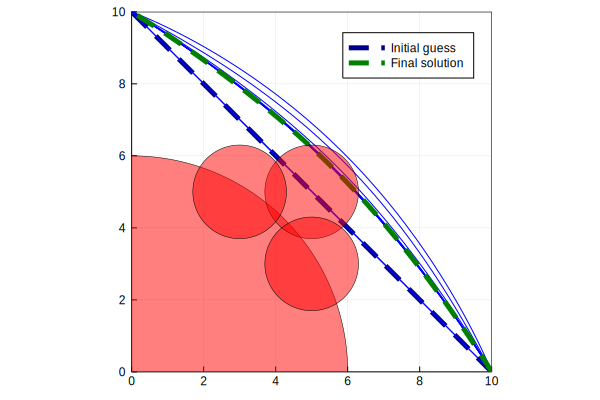

In [211]:
plot_env_solution(model, X_all)